In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
#ONLY FOR COLLAB RUNTIME
%load_ext tensorboard
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
#ONLY FOR COLLAB RUNTIME
!pip install stable-baselines[mpi]==2.10.1 --quiet
!pip install pyvirtualdisplay
!pip install procgen --quiet
!pip install gym --quiet
!pip install gym3 --quiet
!pip install tensorflow-gpu==1.15.2 --quiet

     |████████████████████████████████| 245kB 15.1MB/s 
     |████████████████████████████████| 39.9MB 73kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 675kB 58.1MB/s 
     |████████████████████████████████| 3.3MB 56.7MB/s 
     |████████████████████████████████| 204kB 59.6MB/s 
     |████████████████████████████████| 22.2MB 1.3MB/s 
     |████████████████████████████████| 40kB 6.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 411.0MB 41kB/s 


In [4]:
import sys
sys.path.append('/content/gdrive/MyDrive/CSW182 Final')
#sys.path.append('/content/gdrive/Sharedwithme/CSW182 Final')

In [5]:
import imageio
import time
import numpy as np
import base64
import IPython
import PIL.Image
import pyvirtualdisplay
import pickle

# Video 
from pathlib import Path
from IPython import display as ipythondisplay

# Stable baselines

from helpers import record
from DECOUPLED_ImpalaCnn import ImpalaCnn

from stable_baselines import PPO2
from stable_baselines.common.evaluation import evaluate_policy
from gym3 import ToGymEnv, ViewerWrapper, ExtractDictObWrapper
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from procgen import ProcgenGym3Env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
#logs_base_dir = './runs' # Log DIR
env_id = 'fruitbot'
env = ProcgenGym3Env(num=1, env_name=env_id, distribution_mode='easy', num_levels=100)
states = pickle.load(open('/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/250env.pickle', 'rb'))
env.callmethod("set_state", states)
env = ExtractDictObWrapper(env, key="rgb")
env = ToGymEnv(env)
env = DummyVecEnv([lambda:env])

In [7]:
model = PPO2.load('/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/250decoupled_impala.checkpoint', env = env, policy=ImpalaCnn)





Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [8]:
import matplotlib.pyplot as plt

def run_training(model, steps_per_round=100000,limit=20):
# This function will run a training with value set in `steps_per_round`
# after each round it will measure it's value, If value is under `limit` it will keep training until score limit is reached.  
  score = 0
  best_score = -10000
  score_array = pickle.load(open('/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/dec250score_array.pickle', 'rb'))
  timestep_array = pickle.load(open( '/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/dec250timestep_array.pickle', 'rb'))
  steps_total = timestep_array[len(timestep_array) - 1]

  while score < limit:
      steps_total = steps_total + steps_per_round
      model.learn(total_timesteps=steps_per_round)

      new_evaluation = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
      score = new_evaluation[0]
      timestep_array.append(steps_total)
      score_array.append(score)
      pickle.dump(score_array, open('/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/dec250score_array.pickle', 'wb'))
      pickle.dump(timestep_array, open( '/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/dec250timestep_array.pickle', 'wb'))
      model.save('/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/250decoupled_impala.checkpoint')

      if score > best_score:
        best_score = score
        model.save('/content/gdrive/MyDrive/CSW182 Final/PPO2+DECOUPLED/250decoupled_impala.best')
        #record(model, length=1000) # uncomment to show video from each round
      print('steps_total: ' + str(steps_total))
      print("Mean reward:", score )
    

  # Threshold reached > evaluate over 100 episodes > Video rec/display
  print("Reward limit achived, measuring over 100ep & recording video, please wait...")
  record(model, length=1000)
  ep100 = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
  print("Mean Reward 100 Episodes: ", ep100[0])
  plt.plot(timestep_array, score_array)
  plt.xlabel('Total Timesteps')
  plt.ylabel('Mean reward over 100 different levels')

steps_total: 900000
Mean reward: 10.75
steps_total: 1000000
Mean reward: 8.19
steps_total: 1100000
Mean reward: 13.26
steps_total: 1200000
Mean reward: 12.88
steps_total: 1300000
Mean reward: 10.97
steps_total: 1400000
Mean reward: 10.05
steps_total: 1500000
Mean reward: 10.91
steps_total: 1600000
Mean reward: 13.25
steps_total: 1700000
Mean reward: 12.36
steps_total: 1800000
Mean reward: 13.65
steps_total: 1900000
Mean reward: 15.33
steps_total: 2000000
Mean reward: 15.73
steps_total: 2100000
Mean reward: 13.34
steps_total: 2200000
Mean reward: 15.3
steps_total: 2300000
Mean reward: 12.17
steps_total: 2400000
Mean reward: 12.66
steps_total: 2500000
Mean reward: 15.24
steps_total: 2600000
Mean reward: 13.99
steps_total: 2700000
Mean reward: 13.05
steps_total: 2800000
Mean reward: 14.67
steps_total: 2900000
Mean reward: 14.61
steps_total: 3000000
Mean reward: 14.18
steps_total: 3100000
Mean reward: 14.06
steps_total: 3200000
Mean reward: 15.15
steps_total: 3300000
Mean reward: 15.85
ste

Mean Reward 100 Episodes:  18.09


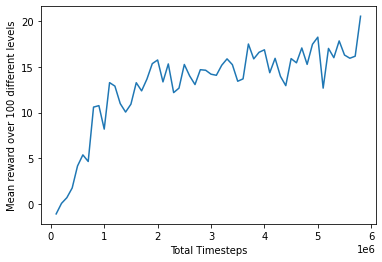

In [9]:
run_training(model)